# 📘 M1 - Data Preparation and Preprocessing

**Curso:** Practical English / Machine Learning M1  
**Ano letivo:** 2025/2026  
**Autor:** Francisco Nunes/Daniel Rodrigues 2022147843/2022103368  
**Data:** 11/11/2025

---

## 🎯 Objective

This notebook presents the **data understanding, cleaning, and preprocessing** stages required for the M1 assignment.  
The goal is to prepare a **binary classification dataset** with:
- 8–30 features (numeric, categorical, and ordinal);
- at least 1,000 rows;
- clear and reproducible preprocessing pipelines.

---

## 🗂 Notebook Outline
1. Data Import and Overview  
2. Exploratory Data Analysis (EDA)  
3. Data Cleaning and Handling Missing Values  
4. Feature Encoding (categorical & ordinal)  
5. Feature Scaling and Outlier Treatment  
6. Pipeline Construction with `scikit-learn`  
7. Train/Test Split and Data Export  
8. Conclusions and Next Steps


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import os
import warnings
warnings.filterwarnings("ignore")

RAW_PATH = "../data/raw/"
PROC_PATH = "../data/processed/"

print("✅ Libraries loaded successfully.")


ModuleNotFoundError: No module named 'seaborn'

In [7]:
from dotenv import load_dotenv, find_dotenv
import os

# Carregar variáveis do ficheiro .env
load_dotenv(find_dotenv())

print("KAGGLE_USERNAME:", os.getenv("KAGGLE_USERNAME"))
print("KAGGLE_KEY:", os.getenv("KAGGLE_KEY")[:5] + "********")


KAGGLE_USERNAME: francisconunes10
KAGGLE_KEY: 55a53********


In [6]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from dotenv import load_dotenv
import pandas as pd
import os

load_dotenv()

# Faz login automático (lê do .env ou pede credenciais)
kagglehub.login()

# Carregar dataset "Stroke Prediction" diretamente
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/stroke-prediction-dataset",
    "healthcare-dataset-stroke-data.csv"
)

print("✅ Dataset carregado com sucesso!")
print("Shape:", df.shape)
df.head()


C:\Users\kikon\AppData\Local\Temp\ipykernel_20176\2577872586.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 310k/310k [00:00<00:00, 768kB/s]

✅ Dataset carregado com sucesso!
Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

--- Missing values ---


bmi                  201
id                     0
age                    0
gender                 0
hypertension           0
heart_disease          0
work_type              0
ever_married           0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64


--- Distribuição do target (stroke) ---


stroke
0    0.9513
1    0.0487
Name: proportion, dtype: float64

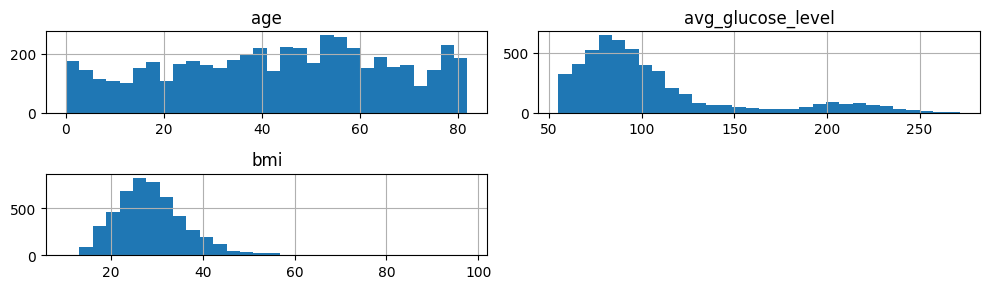

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Shape:", df.shape)
display(df.head())

print("\n--- Info ---")
df.info()

print("\n--- Missing values ---")
display(df.isna().sum().sort_values(ascending=False))

print("\n--- Distribuição do target (stroke) ---")
display(df['stroke'].value_counts(normalize=True).round(4))

# Distribuição de variáveis numéricas
df[['age', 'avg_glucose_level', 'bmi']].hist(bins=30, figsize=(10,3))
plt.tight_layout()
plt.show()


In [10]:

if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Trocar 'Unknown' por NaN
df = df.replace('Unknown', pd.NA)

# Converter colunas object em category
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].astype('category')

# Corrigir possíveis outliers absurdos (idade negativa, etc.)
df = df[(df['age'] >= 0) & (df['age'] <= 120)]

# Verificar resultados
print("Missing depois da limpeza:")
display(df.isna().sum())


Missing depois da limpeza:


gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

In [11]:
target = "stroke"

# Features numéricas e binárias
num_features = ["age", "avg_glucose_level", "bmi", "hypertension", "heart_disease"]

# Categóricas
cat_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

print("Numéricas:", num_features)
print("Categóricas:", cat_features)


Numéricas: ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
Categóricas: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline numérico
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline categórico
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar num único pré-processador
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features)
])


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Aplicar pré-processamento
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)


Train shape: (4088, 20)
Test shape: (1022, 20)


In [15]:
import joblib, numpy as np, os

os.makedirs("../data/processed", exist_ok=True)

joblib.dump(preprocessor, "../data/processed/preprocessor.joblib")
np.save("../data/processed/X_train.npy", X_train_proc)
np.save("../data/processed/X_test.npy", X_test_proc)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

print("✅ Dados processados e guardados em /data/processed/")


✅ Dados processados e guardados em /data/processed/


In [16]:
import numpy as np, pandas as pd

print("X_train:", np.load("../data/processed/X_train.npy").shape)
print("X_test :", np.load("../data/processed/X_test.npy").shape)

print("\ny_train:")
print(pd.read_csv("../data/processed/y_train.csv").value_counts(normalize=True))



X_train: (4088, 20)
X_test : (1022, 20)

y_train:
stroke
0         0.951321
1         0.048679
Name: proportion, dtype: float64
